<a href="https://colab.research.google.com/github/heejookang-sguniv/NLP-/blob/main/6_Attention_is_All_You_Need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6 - Attention is All You Need

120220107 강희주

## Introduction


Natural Language Processing 분야에서 텍스트, 문서 분류, 기계 번역, 챗봇, 문서 요약 등의 작업에는 Recurrent Neural Network(RNN)기반, 또는 RNN + Attention기반의 딥러닝 모델을 대부분 사용하였다. 하지만, RNN 모델의 경우 상당한 계산 복잡도를 가지며, 순차적으로 연산을 하기 때문에 병렬처리가 불가능하다는 점과 단어간의 사이가 멀어질수록 참조가 잘 되지 않는 long-range dependency 문제가 있다. 따라서 이 문제를 해결하기 위해 나온 모델이 바로 transformer이다. 해당 논문에서는 앞서 발생한 문제점들을 해결하기 위해 Self-attention Mechanism을 제시하였으며, RNN이나 LSTM 모델 없이 attention mechanism만을 사용하여 machine translation task를 진행하였고, 매우 좋은 성능을 낸 것을 확인할 수 있다. 
 


In [ ]:
#Colab 사용을 위한 준비
#torchtext.legacy 사용을 위해 torchtext를 0.11.0으로 downgrade
!pip install torchtext==0.11.0
#영어, 독일어 spacy 모델을 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 5.2 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x3973e000 @  0x7f95cacb6615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 20 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does no

## Preparing the Data


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

난수 생성기의 seed를 고정하면, 매번 프로그램을 실행할 때 마다 생성되는 난수들의 수열이 같게 할 수 있다. 이를 통해 반복 실행시, 결과가 재현되도록 해주었다. 

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy는 파이썬의 자연어처리를 위한 오픈 소스 기반 라이브러리로 Tokeniztion(입력 텍스트를 단어, 문장 부호 등의 토큰으로 분류하는 과정), POS Tagging(문장 내 단어들의 품사를 식벼라여 태그를 붙여주는 과정), Dependency Parsing(각 token 들간의 의존관계를 고려하여 관련있는 단어들끼리 묶는 과정) 등의 기능을 제공한다. 

독일어를 위한 spaCy 모델은 "de_core_news_sm"이고, 영어를 위한 모델은 "en_core_web_sm"이며 각 모델의 tokenizer에 접근하기 위해 해당 모델을 로드하였다. 
각 모델의 tokenizer는 문장을 개별 token으로 변환해주는 데 사용된다. 

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

각 언어의 tokenizer를 생성한다. 생성한 함수의 입력으로 들어온 text는 spaCy model의 tokenizer에 입력되어 해당 문자열을 구성하는 개별 토큰으로 분류되며, 정의된 함수의 출력으로는 개별 토큰들로 이루어진 list를 얻게 된다. 

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

torchtext 에는 필드(field)라는 도구를 제공한다. 필드를 통해 앞으로 어떤 전처리를 할 것인지를 정의한다. 

SRC field 안에서는 tokenizer로 tokenize_de 함수(독일어 tokenizer)를 사용하며,init_token 과 eos_token 인수를 통해 sos(start of sequence) 와 eos(end of sequece) 토큰을 추가한다.

`lower = true`를 이용하여 데이터를 모두 소문자로 바꾸겠다고 정의한다.

`batch_first = True` 를 이용하여 미니 batch의 차원을 맨 앞으로 하여 데이터를 불러온다. 

 TPG field 안에서는 tokenizer로 tokenize_en 함수(영어 tokenizer)를 사용하며, 나머지 설정은 전부 SRC field에서와 동일하다.  

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

dataset으로는 Multi30k dataset을 사용하였다. 이는 약 30,000 개의 영어, 독일어, 프랑스어로 이루어진 문장들이 포함되어 있는 데이터이며, 한 문장당 대략 12개의 단어로 구성되어 있다. 

exts는 source와 target으로 사용될 언어를 지정하며(source가 첫번째), fields는 source와 target에서 사용될 전처리 도구인 field를 지정해준다. 
splits 함수를 통해 Multi30k dataset을 분할하여 train, validation, test data를 얻는다.   

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:01<00:00, 803kB/s] 


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 231kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 219kB/s]


source 언어와 target 언어의 *vocabulary*를 생성한다. vocabulary는 각각의 고유한 토큰을 indexing해주는 데 사용된다. source 와 target 언어의 vocabulary는 서로 구분된다. 

min_freq 인수를 사용하여 단어의 빈도 수가 2보다 작은 단어들은 처리하지 않는다. 다시 말해서 빈도 수가 최소 2보다 큰 단어들만 vocaburary에 추가하도록 최소 등장 빈도 조건을 추가하였다. 한번만 등장하는 단어들은 unknown token <unk>로 처리된다.

이때 우리 모델에서 정보 누출을 방지하기 위해 vocabulary는 오직 training set에서만 생성되어야 한다. 정보누출은 인위적으로 부풀려진 validation/test 점수를 제공하므로 방지되어야 한다.  

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

선언한 device는 GPU로 설정이 되었으며, GPU를 사용할 수 없는 경우 CPU를 사용한다. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BucketIterator를 생성한다. 이는 Pytorch의 dataloader와 쓰임새가 같다. 즉, 배치 크기 단위로 값을 차례대로 꺼내어 메모리로 가져오고 싶을 때 사용한다. 

하지만 dataloader와는 다르게 비슷한 길이의 문장들끼리 batch를 만들기 때문에 padding의 개수를 최소화할 수 있다.


자연어 처리를 하다보면 각 문장의 길이가 서로 다를 수 있는데, 병렬 연산을 위해서는 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업이 필요할 때가 있다. 이때 데이터에 특정값을 채워서 데이터의 크기(shape)를 조정하는 것을 padding 이라고 한다.

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Self-Attention 

Self-Attention 이란 입력된 텍스트 데이터 내에 존재하는 단어들 간의 관계를 파악하기 위해 사용된다. 인코더에 입력되는 text data에 존재하는 서로 다른 단어들 간의 관계를 파악하고, 이렇게 파악된 관계 정도에 따라서 서로 다른 가중치를 주기 위해 사용되는 attention 이 바로 self-attention이다. 때문에 입력된 텍스트 데이터에 존재하는 단어들 간의 관계를 잘 파악할 수 있다. 예를 들어 "the dog likes an apple. it has a long tail"이란 입력 데이터가 있을 때 "it"이라는 지시 대명사가 어떤 단어를 가리키고 있는지, 어떠한 단어와 관련이 높은지를 파악하기 위해 self-attention 을 사용하면, "it"과 관련이 높은 단어는 "apple"이 아닌 "dog"임을 파악할 수 있다. 
입력된 데이터를 구성하고 있는 단어들의 정보를 잘 파악할 수 있으면, 입력된 텍스트 데이터가 가진 정보를 상대적으로 정확하게 추출할 수 있기 때문에 더 정확하게 분류문제를 해결할 수 있다. 

self-attention 에서는 encoder에 입력되는 단어들의 임베딩 벡터로 attention score를 구한 후, 이를 이용해 가중치를 구해서 attention 층의 결과물을 얻게 된다. 

단어들은 임베딩 벡터로 표현이 되어있고, 임베딩 벡터들 간의 내적을 통해 얻어진 attention score는 서로 다른 임베딩 벡터들 간의 유사한 정도를 나타낸다. 즉, attention score는 단어들 간의 유사한 정도를 표현한다. 

이때 이전 과제에서 소개된 attention mechanism과 다른 것은, 앞서서는 단어들의 hidden state를 내적해서 attention score를 구하였지만, self-attention의 경우엔 단어들의 임베딩 벡터를 이용해서 내적 연산을 수행하여 단어들 간의 유사한 정도를 파악한다는 것이다. 그 외에 또다른 차이는, self-attention에서는 임베딩 벡터를 직접적으로 사용하지 않는다는 것이다. 임베딩 벡터를 사용해서 서로 다른 세가지 종류의 또 다른 벡터들을 각각의 단어에 대해서 계산하는 과정을 먼저 거친다. 그 벡터들이 바로 *query, key, value* 벡터에 해당한다. key와 value 벡터는 사전 형태의 데이터라고 생각할 수 있다. *key* 벡터 는 사전 데이터에서 id와 같은 역할을 한다(index 역할). *value*벡터는 해당 단어에 대한 구체적 정보를 저장하는 역할을 한다. *query*벡터는 유사한 다른 단어를 찾을 때 사용되는 (질의)벡터라 생각할 수 있다. 이를 이용해서 유사한 다른 단어를 찾게 된다. 

정리하자면, transformer의 self-attention은 입력받은 단어들 중에서 어떠한 단어에 더 많은 가중치를 주어야 하는지 파악하기 위해서 각 단어들에 대한 Query, Key, Value라고 하는 서로 다른 3개의 벡터를 사용한다. 

입력된 각 단어들에 대해서 query, key, value 벡터를 계산하는데, 이때 각각의 가중치 행렬이 사용된다. 즉, query 벡터를 구하기 위해서 query 가중치 행렬을 사용하고, value 벡터를 구하기 위해서 value 가중치 행렬을 사용하며, key 벡터를 구하기 위해서 key 가중치 행렬을 사용한다. 각 가중치 행렬의 요소가 되는 각각의 가중치는 학습을 통해 그 최적값이 계산이 된다. 
 query 벡터를 이용해서 각 key 벡터들과의 유사한 정도(attention score)를 계산한다. 즉, attention score를 얻고자 하는 특정한 단어가 있을 때, 그 단어에 대한 query 벡터와 인코더에 입력이 된 sequence data를 구성하는 모든 단어들에 대한 key 벡터들의 내적 연산을 수행해서 attention score를 구하고 이 값에 softmax 함수를 적용해서 가중치를 구한 다음 이 가중치를 각각의 단어들이 갖고 있는 value 벡터에 곱한 후 모두 더하면, 그것이 우리가 관심있어하는 단어에 대한 self attention의 결과가 된다. 

 이때 실제로는 query, key, value vector들을 row로 하는 query, key, value 행렬로 위의 과정을 거친다. 이렇게 행렬을 이용하면 한번에 모든 단어에 대한 attention을 계산할 수 있다.  


## Building the Model



### Encoder

<img src = "https://drive.google.com/uc?id=1xFY16_EI0e88JNxRuszOQTg1Ida035md" height = 300 width = 300>

Encoder 부분을 살펴보면, 다음의 Encoder block이 N개 사용되며, 해당 논문에서는 이를 6개 사용하였다. 
해당 논문에 첨부된 model architecture를 보면, encoder block의 내부는 2개의 sub-layer로 이루어져 있다. 각각을 살피면 아래와 같다. 


(1)Multi-Head Attention 

인코더에 입력된 sequence data에 self-attention 이 적용되는 sub-layer이다. *Multi-Head*는 self-attention을 여러개 적용했다는 것을 의미한다. 
Multi-Head Attention에서는 h개의 Scaled Dot-Product Attention가 사용되었으며, 하나의 Scaled Dot-Product Attention은 하나의 self-attention에 해당한다. 
scaled Dot-product Attention 의 구조는 다음과 같으며, Encoder의 경우, Scaled Dot-Product Attention 에서 Mask는 사용되지 않는다.

<img src = "https://drive.google.com/uc?id=1q0Cf4YkU42sa-5afNsMDTGA1JPTx0Dhv" height = 300 width = 300>

이때, Q(query)행렬과 K(key)행렬의 transpose와 곱한 다음 softmax 함수를 바로 적용한 것이 아니라 그 전에 *scale*이라는 연산을 하였다. 이때 scale이란 연산은 아래의 식과 같이 $QK^T$에 $\sqrt{d_k}$를 나누어 주는 것을 의미한다. $$ \text{Attention}(Q, K, V) =\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$ 여기서 $d_k$는 key 벡터의 차원에 해당한다. 이렇게 scaling을 해주는 이유는, $QK^T$ 연산을 하게 되면 행렬의 크기가 커지게 되면서 벡터가 커지게 되고, 이때문에 벡터를 구성하는 숫자의 개수가 여러개가 되기 때문에 softmax를 적용하면 거의 대부분의 숫자들이 0에 가깝게 된다. 따라서 각 숫자들의 값들의 차이를 극단적으로 나누기 위해(대부분의 숫자들이 0에 가까운 것을 막기 위해) $\sqrt{d_k}$를 나누어 줌으로써 scaling을 하게 된다. 

<img src = "https://drive.google.com/uc?id=1Mu-0is9QALm2TCOTRoLncFZaGEAHtTeE" height = 300 width = 300>


Multi-Head attention 구조에서는 이러한 역할을 하는 scaled dot-product attention이 h번(해당 논문에서는 8번) 사용이 되었기 때문에 Q,K,V 행렬이 그대로 self-attention layer에 들어가는 것이 아니라 Linear라는 연산을 거친다. 여기서 Linear 연산은 정확하게는 *Linear projection*을 의미한다. 이는 특정한 형태의 가중치 행렬을 한번 더 곱했다는 것을 의미한다. V라는 행렬을 그대로 self-attention에 사용하는 것이 아니라 value 행렬 V에 또다른 가중치 행렬${W_{i}^{V}}$을 곱한 결과를 scaled dot-product attention 의 입력으로 사용을 한 것이며, query 행렬 Q와 key 행렬 K에도 마찬가지로 ${W_{i}^{Q}}$, ${W_{i}^{K}}$ 를 곱한 결과를 입력으로 사용하였다. 이를 수식으로 표현한 것이 아래의 식에 해당한다.  

$$ \begin{matrix}
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O\\
\text{where}~\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K,VW_i^V)
\end{matrix} $$

아래의 식에서 하나의 head는 하나의 self-attention을 통해 얻은 결과를 의미한다. 때문에 h개의 head가 사용이 된것이다. 

이렇게 linear projection을 수행한 결과를 입력으로 쓰는 이유는 행렬의 행렬을 구성하는 벡터들의 차원을 맞춰주기 위한 것이다. h개의 scaled dot-product attention를 통해 얻은 h개의 결과를 concat한 것이 multi-head attention의 결과가 되는데, 이 결과의 차원은 미리 설정된 ${d_{model}}$차원이 되어야 한다. Q, K, V에 속한 query, key, value 벡터들의 차원은 ${d_{model}}$로 동일한데, h개의 결과를 concat 했을 때도 ${d_{model}}$을 유지해야하므로, 각각의 query, key, value 벡터들의 차원은 $d_{\text{model}}/h$가 되어야 한다. 따라서 벡터의 차원을 바꾸어주기 위해 linear projection을 위한 $QW_i^Q, KW_i^K,VW_i^V$ 행렬은 모두 ${d_{model} \times d_{model/h}}$가 되어야 한다.

위와 같이 하나의 self-attention이 아니라 여러개의 self-attention 즉 multi-head attention을 사용한 이유로는 2가지가 존재한다. 첫번째로는, 입력 sequence data에 존재하는 다른 단어들 중 어떤 단어가 관련이 더 많은지 또는 적은지를 여러개의 self-attention을 사용함으로써 더 잘 파악할 수 있다. 두번째로는 단어들의 관계를 더 잘 파악하게 되면, 하나의 단어가 문장에서 갖는 문맥적 특징/정보를 더 잘 추출할 수 있기 때문이다. 


(2) Position-wise Feed-Forward Networks 

2개의 fully connected layer(혹은 dense layer)로 구성되었으며, Token 마다(즉, position마다) 독립적으로 동일하게 적용한다. fully connected layer가 각각의 단어에 적용되는 연산을 하나의 수식으로 표현하면 아래의 식과 같다. 

$$ \text{FFN}(x)=\max(0, xW_1+b_1)W_2+b_2 $$

위의 수식에서 $\max(0, xW_1+b_1)$ 부분은 첫번째 FC(fully connected) layer가 적용된 부분이다. 여기서 max fuction이 들어간 이유는 첫번째 FC layer에서는 Relu 활성화 함수가 사용됐기 때문이다. 두번째 FC layer는 아무 활성화 함수도 갖고 있지 않다. $W_1$는 입력벡터와 첫번째 FC layer 사이의 가중치 행렬에 해당한다. $W_2$는 첫번째 FC layer와 두번째 FC layer 사이에 존재하는 가중치 행렬에 해당한다. 


 

### positional embedding 

첫번째 encoder block에 들어가는 입력값은 각각의 token들이 갖고 있는 임베딩 벡터만을 사용하지 않고, 추가적인 벡터 정보를 더해서 그 결과를 최종적인 임베딩 벡터로 사용을 하였다. 이렇게 추가한 임베딩 정보가 바로 positional embedding이란 정보이다. positional embedding 벡터는 각각의 단어가 입력된 전체의 sequence 데이터에서 갖는 위치정보를 반영을 한다. 따라서 원래의 임베딩 벡터와 위치정보를 담고 있는 positional embedding 벡터를 더해서 최종적인 하나의 512차원의 벡터를 각각의 단어들에 대해서 생성할 수 있으며, 이러한 512차원의 벡터가 첫 번째로 나오는 encoder block의 제일 아래 부분에 위치한 sub-layer인 multi-head attention의 입력값으로 들어가게 된다. transformer algorithm에서는 RNN 기반의 encoder-decoder 모형처럼 단어들의 임베딩 벡터만을 사용한 것이 아니라, 추가적으로 위치정보를 담고 있는 positional embedding 벡터를 사용하였다. 그 이유는 다음과 같다. 

transformer가 적용이 되고 있는 데이터는 text 데이터인데, text 데이터는 단어들이 순차적으로 연결이 된 sequence 데이터이다. 이러한 sequence 데이터는 각각의 단어가 어떠한 위치에서 몇 번째로 사용이 되었는지, 그리고 주변의 어떠한 단어들과 함께 사용이 되었는지에 대한 정보를 추출하는 것이 중요한데, RNN/LSTM 기반의 방법들의 경우에는 단어들이 RNN/LSTM에 순차적으로 적용이 된다. 즉, 첫번째 단어가 먼저 입력이 되면 어떠한 연산을 통해서 hidden state 정보를 추출하고 다음 스텝에서 두번째 단어가 입력돼서 연산을 거쳐 해당 단어의 정보를 추출하는 과정을 이후 스텝에서도 계속 반복한다. 이때 두번째 단어의 hidden state 정보를 추출하기 위해서 첫번째로 입력이 된 단어의 hidden state 정보를 이용한다. 이렇게 단어들이 순차적으로 입력이 되기 때문에 RNN 기반의 방법에서는 단어들의 순서정보를 어느정도 파악할 수 있다. 하지만 transformer에서는 RNN을 사용하지 않고 attention만을 사용하기 때문에 순서 정보를 파악하는 것이 상대적으로 더 어렵다. 따라서 단어들이 갖고 있는 상대적인 위치 정보를 파악하기 위해 추가적으로 사용하는 정보가 바로 각각의 단어들에 대한 위치정보를 담고 있는 positional embedding 벡터를 사용하는 것이다.  


positional embedding 벡터의 값은 학습을 통해서 그 원소의 값들이 계산되지 않는다. 어떠한 특정한 공식을 통해 계산을 하고, 그렇게 계산이 된 정보를 가져다가 사용하는 것이다. 즉, positional embedding 벡터의 값은 학습이 되는 parameter에 해당하지 않는다. positional embeddign vector의 원소의 값을 계산하는 식은 아래와 같다. 
$$ \begin{matrix}
PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{\text{model}}})\\
PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{\text{model}}})
\end{matrix} $$

여기서 $PE_{(pos, j)}$ 는 단어 *pos*의 positional embedding 벡터의 위치 j의 원소값을 의미하며, j가 짝수(2i)인 경우에는 첫번째 공식을 사용하고, j가 홀수(2j+1)인 경우에는 두번째 공식을 사용하여 원소값을 계산한다. 


In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        '''
        nn.Embedding()은 룩업 테이블 과정을 수행한다. 즉, 특정 토큰과 맵핑되는 정수(이는 vocabulary에서 지정됨)를 인덱스로 가지는 
        테이블(임베딩 테이블)로부터 임베딩 벡터 값을 가져온다. nn.Embedding()은 크게 두 가지 인자를 받는데, 각각 input_dim과 hid_dim 이다. 
        input_dim은 임베딩을 할 단어들의 개수로, 다시 말해 단어 집합의 크기이며, 임베딩 테이블은 인자로 받은 단어 집합의 크기만큼 행을 가진다. 
        hid_dim은 특정 토큰과 맵핑되는 정수를 인덱스로 가지는 벡터(즉, 임베딩 벡터)의 차원에 해당하며 , 이는 사용자가 정해주는 하이퍼파라미터이다. 
        '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        '''
        <sos> token부터 문장의 최대 길이로 설정한 max_length =100까지 positional embedding 을 한다.  
        '''
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        '''
        nn.ModuleList 함수를 통해 EncoderLayer 모듈을 리스트 형태로 저장하였다. n_layers의 개수만큼 EncoderLayer 모듈이 list에 저장이 된다. 
        해당 논문에서는 총 6개의 EncoderLayer 모듈을 사용했지만, 해당 코드에서는 총 3개의 EncoderLayer 모듈을 사용하였다. 
        nn.ModuleList를 이용하면 파이썬의 일반적인 리스트처럼 인덱스로 접근이 가능하다.   
        '''
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        #dropout은 overfitting을 해결할 수 있는 방법 중 하나로, 일부 파라미터를 학습에 반영하지 않음으로써 모델을 일반화하는 방법이다.
        self.dropout = nn.Dropout(dropout)
        
        #self.scale은 key 벡터의 차원에 root를 취한 값의 역할을 한다.
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        #소스 문장의 임베딩 벡터와 positional embedding 벡터를 더해준다.  
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        '''
        모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        src_mask는 padding된 부분을 관리하기 위한 객체에 해당한다. 
        encoder 내부의 encoder layer에 입력문장 src를 통과시키며, encoder layer를 거치는 과정을 총 (self.layers)번 반복한다. 
        하나의 encoder layer는 2개의 sub-layers(multi-head self-attention layer, position-wise FeedForward layer)과 2개의 Add&Norm layer로 이루어져 있다.    
        '''
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
        #마지막 레이어의 출력을 반환한다.     
        return src

### Encoder Layer

앞서 소개한 두개의 sub-layer 외에도 Add & Norm layer를 추가하여 성능을 높였다. 

Add : 이 부분에서는 self-attention 층이 출력하는 값과 self-attention에 입력된 값을 더해준다. 

Layer normalization : FeedForward NN 에서 발생할 수 있는 과적합 문제를 해결하기 위해서 사용하는 normalize 방법이며, 각 input의 feature들에 대한 평균과 분산을 구해서 batch에 있는 각 input을 normalization 하는 방법이다. 

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        '''
        Multi-head self-attention을 수행하는 코드이다. 
        하나의 입력값 src를 통해 query, key, value 값을 생성한다. decoder와 다른 부분에 해당한다. 
        필요한 경우 마스트(mask) 행렬을 이용하여 attention 할 단어를 조절 가능하다. 
        '''
        _src, _ = self.self_attention(src, src, src, src_mask)
        

        #dropout, residual connection and layer norm
        '''
        Multi-head self-attention을 수행하여 얻은 결과(_src)에 입력문장(src)를 더한 후,
        과적합 문제를 해결하기 위해서 normalization을 해준다. 
        이 과정은 Add&Norm layer에 해당한다. 
        '''
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        # Add&Norm layer의 결과값으로 얻은 src는 두개의 FC(fully connected) layer로 이루어진 position-wise feedforward layer를 통과한다. 
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        '''
        position-wise feedforward layer를 통과하여 얻은 결과(_src)에 해당 layer의 입력(src)를 더한 후, 
        과적합 문제를 해결하기 위해서 normalization을 해준다. 
        '''
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        #마지막 레이어의 출력을 반환한다. 
        return src

### Mutli Head Attention Layer

아래의 코드는 앞서 설명한 encoder block의 두개의 sub-layer중 multi head attention layer에 해당한다. 해당 코드에서는 h = 8개의 Scaled Dot-Product attention 연산을 수행하며, linear projection을 하기 전의 query, key, value 벡터의 차원은 ${d_{model} = 512}$에 해당한다. 때문에 linear projection 을 위한 각각의 가중치 행렬 $QW_i^Q, KW_i^K,VW_i^V$ 의 크기는 $512 \times 64$가 되며, linear projection 을 거친 후의 query, key, value 벡터의 차원은  $ d_k=d_v=d_{\text{model}}/h = 64 $ 가 된다. 

(querie와 key 벡터는 $d_k$ dimension을 가지고 value 벡터는 $d_v$ dimension을 가짐)

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    '''
    encoder와 decoder의 multi-head attention 부분에 해당한다.
    (임베딩 된 sequence + positional embedding 벡터)에 self-attention 을 적용한 후, 
    그 결과를 다음 layer(Add&Norm)의 input으로 보낸다.  
    '''

    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim #하나의 단어에 대한 임베딩 차원 
        self.n_heads = n_heads #헤드(head)의 개수 : 서로 다른 scaled dot-product attention의 개수
        self.head_dim = hid_dim // n_heads #각 헤드(head)에서의 임베딩 차원 -> 각 헤드의 차원 * 헤드의 개수 = hid_dim(임베딩 차원) 이어야 함
        '''
        해당 논문에서는 query, key, value는 linear projection에 의해 d_model에서 d_model/h의 차원으로 바꾸어 준다고 했지만,
        코드 구현에서는 hid_dim(d_model)에서 hid_dim(d_model)로 맵핑해준 다음, 결과로 얻은 hid_dim 차원을 h개로 쪼개서 사용하였다. 
        '''
        self.fc_q = nn.Linear(hid_dim, hid_dim) # Query 값에 적용될 FC 레이어 
        self.fc_k = nn.Linear(hid_dim, hid_dim) # Key 값에 적용될 FC 레이어 
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        #각각의 query,key,value의 차원에 해당하는 self.head_dim에 root를 씌운 값을 나누어서 softmax 함수에 넣어줄 수 있도록 만든 것
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim] 이때 query len은 단어의 개수에 해당한다. 
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        #query, key, value를 각각 Q,K,V에 맵핑을 해준다.        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        '''
        Q,K,V를 각각 n_heads개로 나누어 사용하기 위해, 각각을 hidden_dim -> n_heads * head_dim 의 형태로 변형해준다.
        즉, n_heads 개 각각마다 head_dim 의 차원을 가지도록 만들어 준다. 이는 각각 n_heads 개의 query, key, value를 만들어준것과 같다. 

        '''
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        '''
        Attention energy 즉, attention score를 계산하는 코드이다. 
        각각의 head 마다 Q(query)와 K(key)를 서로 곱해준 후, 앞서 구한 self.scale로 나누어 주어서 energy(attention score)를 구한다.         
        '''
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        '''
        필요하다면 마스크를 씌울 수 있다. 
        마스크(Mask)를 사용하는 경우에는, 마스크 값이 0인 부분을 (-무한대)에 가까운 값인 -1e10으로 채워준다.  
        따라서 softmax 함수를 적용하였을 때의 결과값이 0이 될 수 있도록 만들어준다. 
        '''
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        '''
        energy에 softmax 함수를 적용하여 attention 가중치 값을 구함
        attention 가중치 값은 각 단어에 대한 확률 값에 해당한다. 
        '''
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        #앞에서 얻은 attention 가중치 값들을 V(value)와 곱하면 최종적으로 우리가 관심있어하는 단어에 대한 self attention의 결과를 얻을 수 있다.        
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        '''
        view를 이용하여 x를 다시 일자로 쭉 늘어뜨려서, concat을 수행한 것과 동일한 결과를 얻을 수 있다. 
        '''
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        #마지막으로 output linear 함수를 거친 후, 결과 x와 attention 가중치를 정의하고 있는 함수의 결과로 출력한다. 
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

아래의 코드는 앞서 설명한 encoder block의 두개의 sub-layer중 Position-wise Feedforward layer에 해당한다. 해당 논문에서 input과 output의 dimension은 ${d_{model} = 512}$이며, inner-layer의 dimension은 ${d_{ff} = 2048}$이다. 일반적으로 inner-layer의 dimension은 input과 output의 dimension보다 훨씬 크게 설정하며, 첫번째 FC layer과 두번째 FC layer 사이에서 Relu 활성화 함수와 dropout을 적용한다. 

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        '''
        fc_1 layer의 입력으로 hid_dim 만큼의 차원이 입력되었을 때, 
        fc_2 layer의 출력으로 hid_dim 만큼의 차원을 그대로 내보낸다. 
        즉 입력과 출력의 차원이 동일하다. 
        '''
        self.fc_1 = nn.Linear(hid_dim, pf_dim)  
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        #활성화 함수 ReLu는 fc_1 layer에만 적용된다. 
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

<img src = "https://drive.google.com/uc?id=1nypaHsZJDnZShwK7CJx5-X9F7f09JQzX" height = 600 width = 300>

Transformer의 Decoder 부분은 seq2seq의 decoder와 비슷한 역할을 한다. 즉, encoder에 입력된 sequence data에 대한 또 다른 sequence data를 출력한다. sequence data가 텍스트인 경우, decoder는 언어 모형이라고 생각할 수 있다. 

Decoder block의 전체적인 구조는 앞에서 설명한 encoder block과 유사하지만 주요 차이는 두가지 종류의 attention이 사용된다는 것이다. 

먼저, Masked multi-head attention layer가 사용된다. *Masking*이라는 작업이 어떤 식으로 self-attention에서 적용이 되는지를 이해하기 위해서는 transformer의 디코더에서 사용되는 *Teacher forcing*이라는 방법을 알아야 한다. 

디코더는 언어 모형의 역할을 한다. 만약 예측해야하는 영어 문장이 "Today is friday"라면, 인코더에서 넘어온 정보와 sos token의 인베딩 벡터를 이용해 Today를 예측한다. 그 다음엔 'today'까지 포함에서 'is'를 예측하며, 또 다음 단계에서는 'is'까지 포함해서 'friday'를 예측한다. 이렇게 단어를 예측하는 역할을 하는 것을 언어모형이라 하며, 트랜스포머에서 해당 역할을 하는 것이 디코더이다. 

이때 디코더는 언어 모형의 역할을 하지만, *학습*의 단계에서는 모형이 현재 단계까지 에측한 단어들의 정보를 사용하여 다음 단어를 예측하는 것이 아니라, 정답 데이터 정보를 이용해서 각 단계의 단어들을 예측한다. 이를 *Teacher forcing*이라 하는데, 이러한 방법을 사용하는 이유는 모형이 예측한 단어들의 정보를 이용해서 다음 단어를 예측하는 경우에는 이전 단어들에 대한 예측이 잘못되면 그 다음 단어에 대한 예측이 제대로 될 수 없기 때문이다. 다시 예를 들어 "Today is friday"라는 문장을 예측해야 하는 경우, 만약 첫단어를 'today'라고 예측하지 못하면, 그 다음 단어인 'is'를 제대로 예측할 수 없을 것이다. 이를 위해 학습에서는 첫단어를 'today'를 예측하지 못했어도, 'is'를 예측할 때는 실제 정답 데이터인 'today'를 사용하여 학습한다.

즉, 디코더에서는 *Teacher forcing* 방법을 사용하기 때문에 각 단계에서의 단어를 예측할때는 정답 sequence인 'sos', 'today', 'is', 'friday' 이라는 4개의 token들을 학습 데이터로 사용하여 학습하는데, 해당 토큰들은 가장먼저 Masked multi-head attention layer에 입력으로 들어간다. 이때 토큰들의 임베딩 벡터들이 바로 들어가는게 아니라, positional embedding 정보를 사용해서 query, key, value 벡터를 구하여 얻은 attention score에 softmax function 적용 후 가중치를 구한 다음, 가중치를 각각의 단어에 대한 value 벡터에 곱하고 component끼리 더하게 되면 각 단어에 대한 self-attention 결과물이 도출이 된다.

하지만, 예를 들어 Friday 라는 단어를 예측할 때, 정답 데이터에 존재하는 단어들 중 is 까지의 정보를 사용해야한다. 다시말해, is 다음에 오는 단어인 friday 라는 단어의 attention score는 사용하면 안된다. 따라서 사용하지 않기 위해서, friday와 is 라는 단어 사이에 존재하는 attention score를 (-무한대)로 바꾼다. 이렇게 특정 attention score를 (-무한대)로 바꾸는 방법을 *masking* 방법이라고 한다. attention score를 (-무한대)로 바꾸었을 때, 여기에 softmax 함수를 적용하면 해당 가중치의 값은 0이 된다.0에 해당 단어의 value 벡터를 곱하면 벡터의 모든 원소가 전부 0이 된다. 즉, 해당 단어의 정보를 사용하지 않게 되는 것이다. 즉, 디코더는 언어 모형으로 작동하기 때문에 학습 과정에서 정답 데이터를 이용해서 특정 위치에 존재하는 단어를 예측하고자 할 때, 기준이 되는 단어 다음에 나오는 단어의 정보를 사용하면 안된다. 그러한 단어의 정보를 사용하지 않기 위해서 해당 단어에 대한 attention score의 값을 (-무한대)로 대체하여 가중치가 0이 되게 함으로써 해당 단어의 정보를 사용하지 않도록 한다. 이러한 masking 방법을 사용한 multi head attention 을 적용하기 때문에 해당 layer의 이름이 *Masked multi head attetion*이라 붙은 것이다. 


디코더에서 사용되는 또다른 attention은 *multi head attention(encoder attention)*으로 self-attention 과 마찬가지로 query, key, value 벡터들을 사용한다. query 벡터는 디코더 부분에 입력된 단어에 대한 query 벡터를 사용한다. 때문에 디코더 부분에 입력된 단어의 query 벡터를 계산하기 위해서 해당 attention layer 아래에 있는 Add & Norm 층이 출력하는 결과를 이용한다. key와 value 벡터는 인코더 부분에 입력된 각 단어에 대한 key, value 값을 사용한다. 작동하는 방식은 앞에서 설명한 self-attention과 동일하다. 




In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        '''
         nn.Embedding()은 룩업 테이블 과정을 수행한다. 즉, 특정 토큰과 맵핑되는 정수(이는 vocabulary에서 지정됨)를 인덱스로 가지는 
        테이블(임베딩 테이블)로부터 임베딩 벡터 값을 가져온다. nn.Embedding()은 크게 두 가지 인자를 받는데, 각각 output_dim과 hid_dim 이다. 
        output_dim은 임베딩을 할 단어들의 개수로, 다시 말해 단어 집합의 크기이며, 임베딩 테이블은 인자로 받은 단어 집합의 크기만큼 행을 가진다. 
        hid_dim은 특정 토큰과 맵핑되는 정수를 인덱스로 가지는 벡터(즉, 임베딩 벡터)의 차원에 해당하며 , 이는 사용자가 정해주는 하이퍼파라미터이다. 
        '''
        self.tok_embedding = nn.Embedding(output_dim, hid_dim) 
        '''
        <sos> token부터 문장의 최대 길이로 설정한 max_length =100까지 positional embedding 을 한다. 
        '''
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        '''
        nn.ModuleList 함수를 통해 DecoderLayer 모듈을 리스트 형태로 저장하였다. n_layers의 개수만큼 DecoderLayer 모듈이 list에 저장이 된다. 
        해당 논문에서는 총 6개의 DecoderLayer 모듈을 사용했지만, 해당 코드에서는 총 3개의 DecoderLayer 모듈을 사용하였다. 
        nn.ModuleList를 이용하면 파이썬의 일반적인 리스트처럼 인덱스로 접근이 가능하다.   
        '''
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len] -> teacher forcing을 하기 위한 정답 sequence data에 해당한다.  
        #enc_src = [batch size, src len, hid dim] -> 인코더의 마지막 layer에서 출력된 출력값
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        '''
        0부터 target 문장을 구성하고 있는 단어의 개수인 trg_len까지의 위치에 대한 정보가 담겨야 하기 때문에
        하나의 tensor를 초기화한 후에, 각 문장에 대해서 반복할 수 있게 해준다.  
        '''
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        
        #문장의 임베딩 벡터에 positional embedding 벡터를 더한 것을 실제 디코더의 입력으로 사용함
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        #디코더 layer를 여러번 거친 후, 마지막으로 출력이 된 output값이 trg에 해당한다.  
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        #trg가 출력을 위한 linear layer를 거치도록 만들어준다. 
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        #Masked multi-head attention을 수행한다. 
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        #인코더 레이어에서 설명한 add&norm 과 동일한 과정을 수행 
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        '''
        디코더 block에 입력된 단어들에 대한 query 벡터와 인코더 block에 입력된 
        각각의 단어들에 대한 key, value 벡터를 사용해서 self-attention 수행
        '''
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder #전체 인코더 아키텍쳐
        self.decoder = decoder #전체 디코더 아키텍쳐
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        #src 문장의 <pad> 토큰에 대하여 마스크(mask)값을 0으로 설정
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    # 타켓 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록)만들기 위해 마스크를 사용함
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        #순서대로 앞쪽에 있는 단어들만 볼수 있도록 만들기 위해서 마스크 행렬 생성 
        '''(마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        '''
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask #element-wise 로 AND 연산 수행 
        
        #trg_mask = [batch size, 1, trg len, trg len]
        '''
        결과적으로 두 마스크(pad_mask 와 sub_mask)의 곱이 1이 되는 위치에 대해서만
        가중치를 가질수 있도록 만들어서 mask 값을 생성함 
        '''
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]

        #src와 trg이 들어왔을 때, mask를 각각 생성한다. 
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        #인코더에 소스 문장을 입력함
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
        
        #디코더는 인코더의 출력값인 enc_src와 타켓문장 trg를 통해 학습하며, 마지막으로 나온 output이 바로 번역 결과에 해당함 
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model



In [ ]:
INPUT_DIM = len(SRC.vocab) #SRC 코퍼스에 포함된 토큰의 개수
OUTPUT_DIM = len(TRG.vocab) #TRG 코퍼스에 포함된 토큰의 개수 
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

#인코더와 디코더 객체 선언
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

#transformer 객체 선언 
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [ ]:
# 모델 가중치 파라미터 초기화 
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

#adam optimizer로 학습함 
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
'''
Loss function으로는 CrossEntropyLoss를 사용함 
뒷 부분의 패딩(padding)에 대해서는 값 무시 즉 <pad> token에 대해서는 loss 계산을 하지 않도록 조건을 부여함 
'''
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
#모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        #출력 단어의 마지막 인덱스<eos>는 제외
        #입력을 할 떄는 <sos>부터 시작하도록 처리 
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        #출력 단어의 인덱스 0<sos>는 제외 
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        #모델의 출력 결과와 타겟 문장을 비교하여 손실 계산    
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        #전체 손실값 계산 
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #validation loss 가 더 감소하는 경우에만 모델 파라미터를 기록하도록 만듬 
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.238 | Train PPL:  69.250
	 Val. Loss: 3.026 |  Val. PPL:  20.619
Epoch: 02 | Time: 0m 18s
	Train Loss: 2.821 | Train PPL:  16.799
	 Val. Loss: 2.316 |  Val. PPL:  10.133
Epoch: 03 | Time: 0m 19s
	Train Loss: 2.237 | Train PPL:   9.368
	 Val. Loss: 1.988 |  Val. PPL:   7.302
Epoch: 04 | Time: 0m 18s
	Train Loss: 1.881 | Train PPL:   6.558
	 Val. Loss: 1.806 |  Val. PPL:   6.087
Epoch: 05 | Time: 0m 18s
	Train Loss: 1.635 | Train PPL:   5.131
	 Val. Loss: 1.703 |  Val. PPL:   5.492
Epoch: 06 | Time: 0m 18s
	Train Loss: 1.444 | Train PPL:   4.239
	 Val. Loss: 1.663 |  Val. PPL:   5.274
Epoch: 07 | Time: 0m 18s
	Train Loss: 1.292 | Train PPL:   3.639
	 Val. Loss: 1.616 |  Val. PPL:   5.034
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.166 | Train PPL:   3.208
	 Val. Loss: 1.620 |  Val. PPL:   5.052
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.057 | Train PPL:   2.876
	 Val. Loss: 1.642 |  Val. PPL:   5.163
Epoch: 10 | Time: 0m 18s
	Train Loss: 0.961 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.672 | Test PPL:   5.321 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval() #평가 모드 
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)] #문장(sentence)가 입력되었을 때, 토큰화 진행 
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기 
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'holding', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

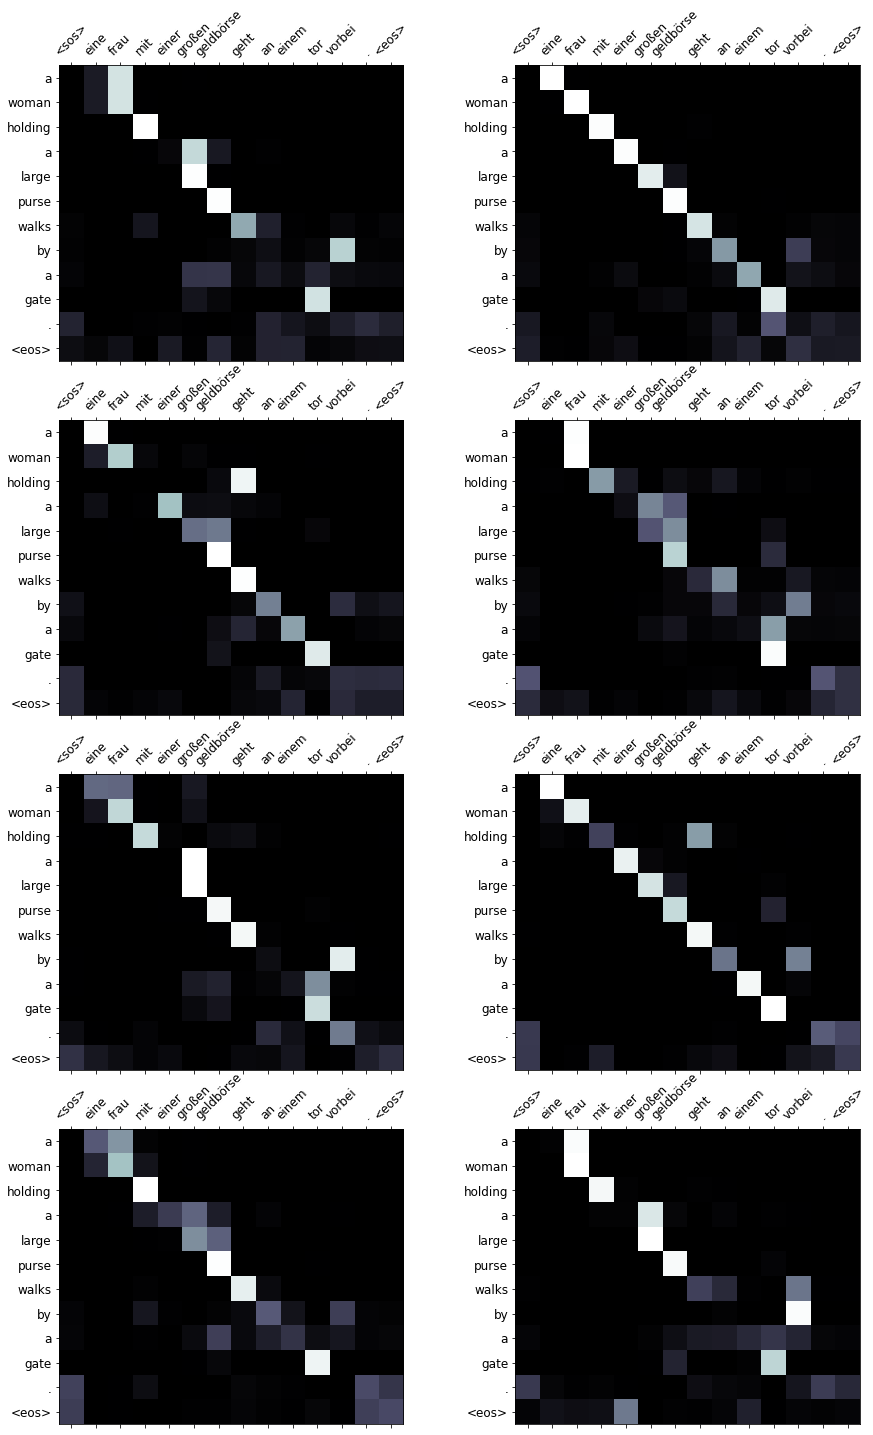

In [ ]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


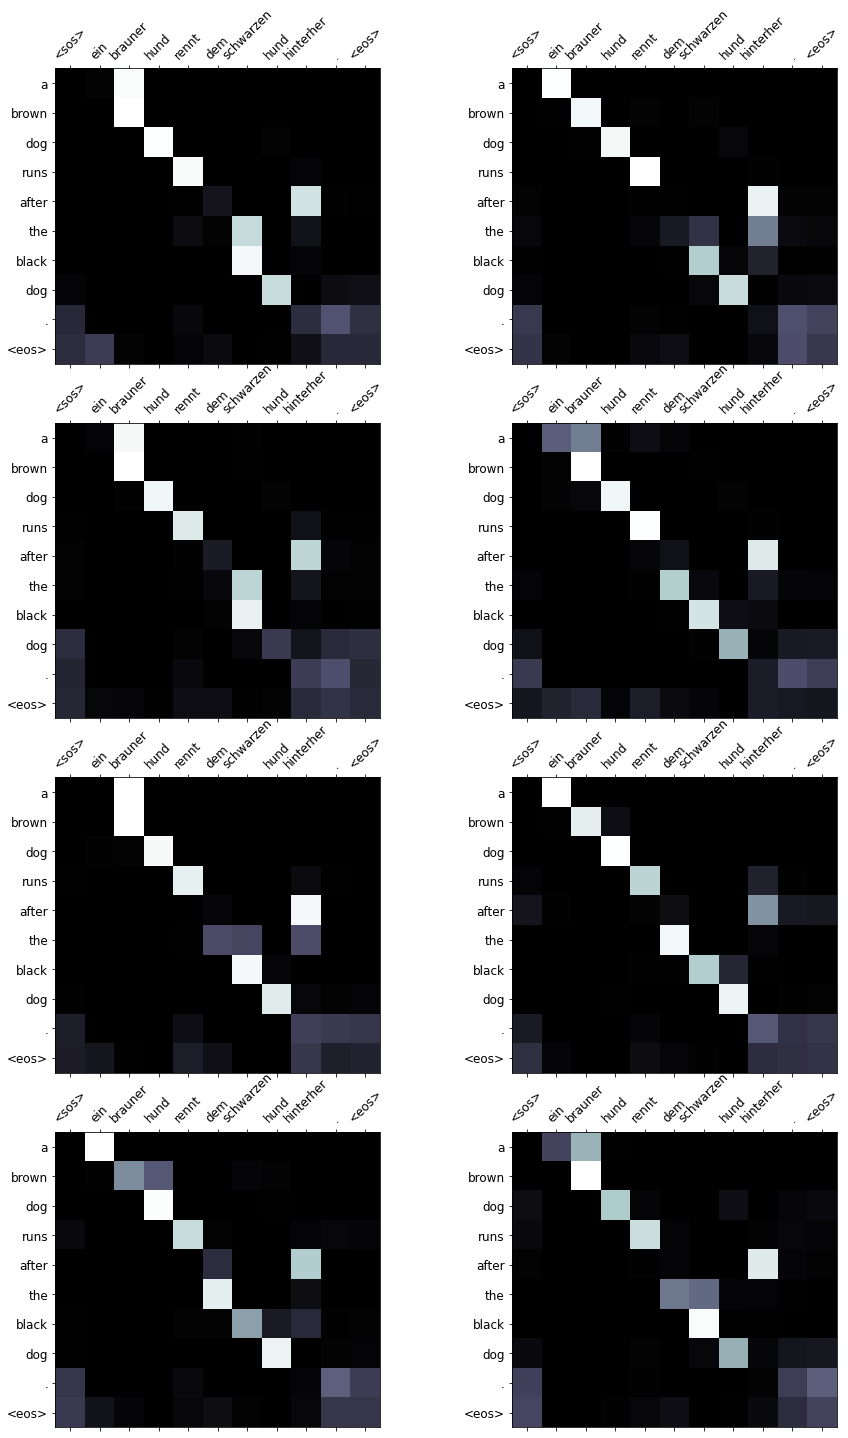

In [ ]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


<ipython-input-30-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-30-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


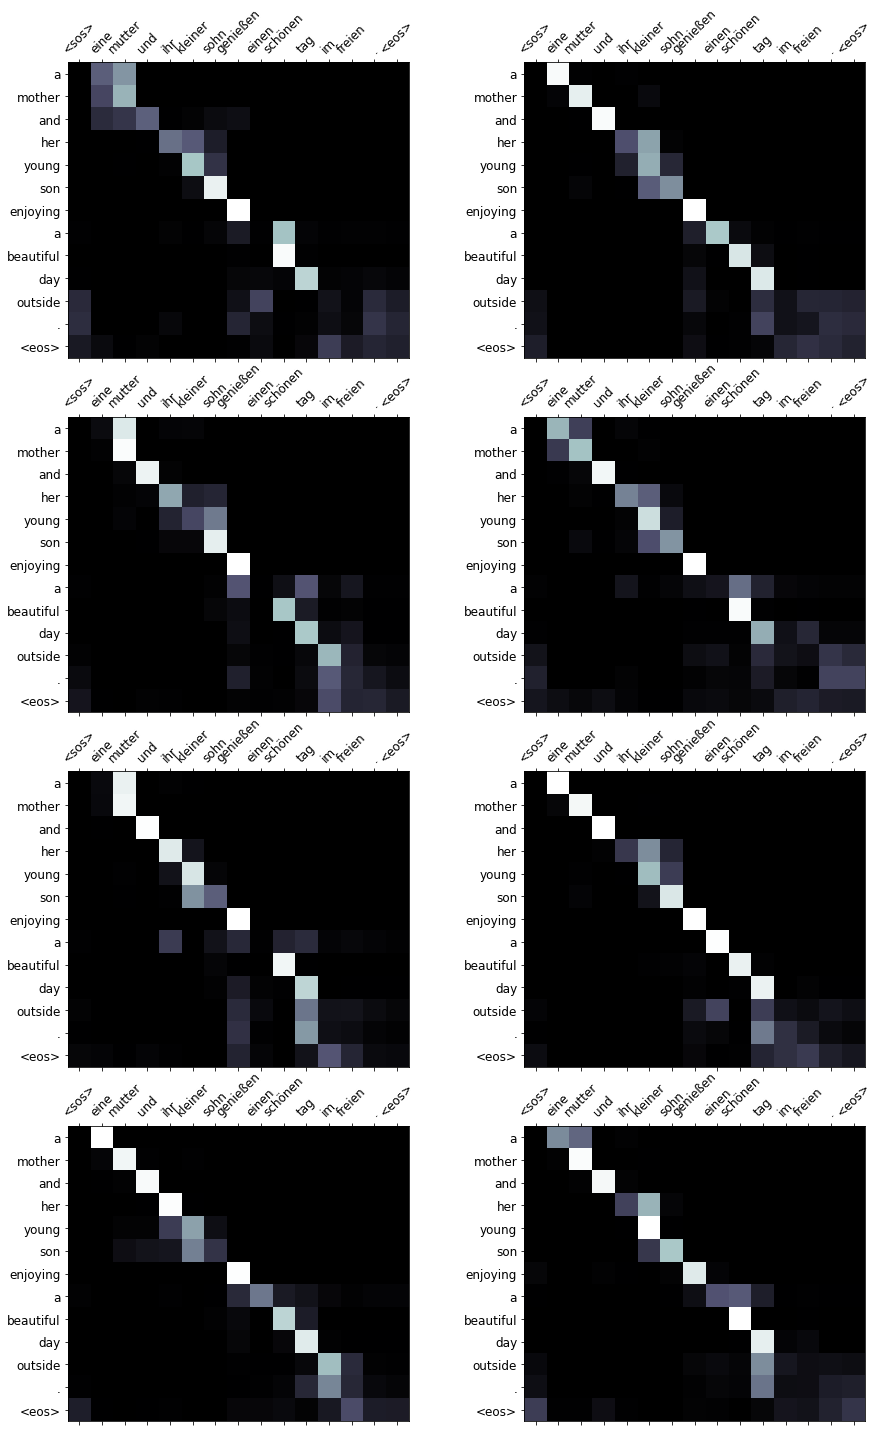

In [ ]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.52


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)